## Лабораторная 9
Датасет: Vehicle Type Recognition (https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition)

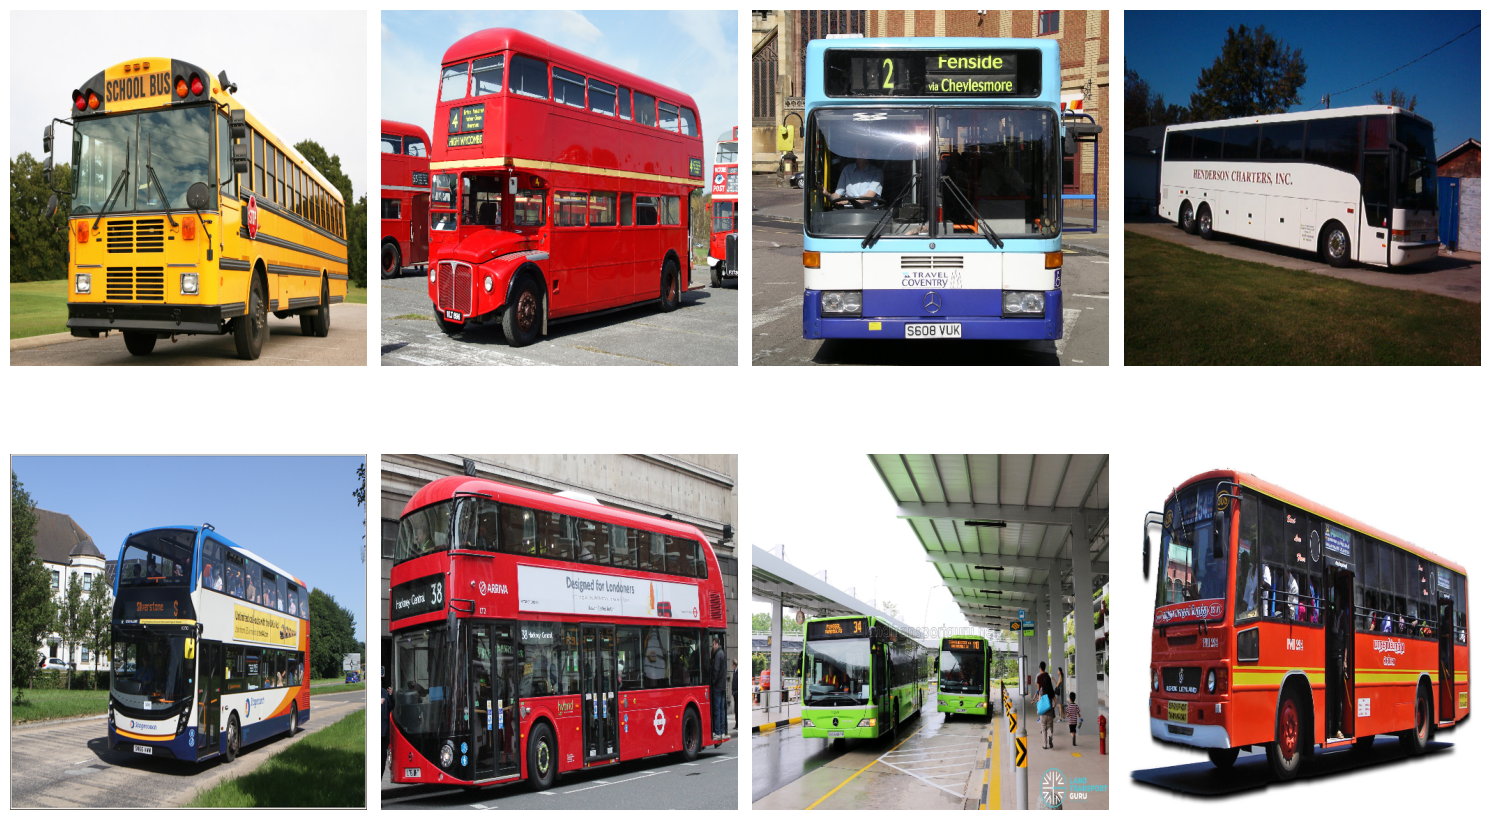

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

def load_images_from_folder(folder, target_size=(512, 512)):
    images = []
    labels = []
    for label in os.listdir(folder):
        if label in ['Bus', 'Car', 'motorcycle', 'Truck']:
            label_folder = os.path.join(folder, label)
            if os.path.isdir(label_folder):
                for filename in os.listdir(label_folder):
                    img_path = os.path.join(label_folder, filename)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img_resized = cv2.resize(img, target_size)
                        images.append(img_resized)
                        labels.append(label)
    return images, labels

folder_path = "static/Dataset"
images, labels = load_images_from_folder(folder_path)

num_images_to_display = min(8, len(images))

if images:
    cols = 4
    rows = num_images_to_display // cols + (num_images_to_display % cols > 0)

    plt.figure(figsize=(15, 5 * rows))
    for i in range(num_images_to_display):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

images = np.array(images)  
labels = np.array(labels)

Предобработка изображений

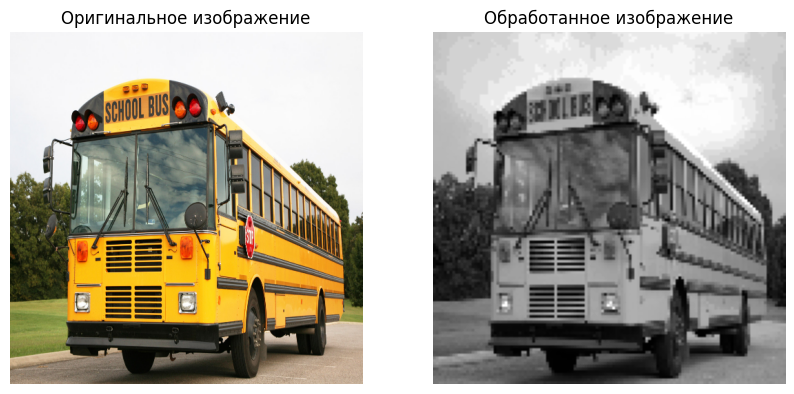

In [ ]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, (128, 128))
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_eq = cv2.equalizeHist(img_gray)
        processed_images.append(img_eq)
    return np.array(processed_images)

processed_images = preprocess_images(images)

def display_single_image(original, processed, index):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original[index], cv2.COLOR_BGR2RGB))
    plt.title('Оригинальное изображение')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed[index], cmap='gray')
    plt.title('Обработанное изображение')
    plt.axis('off')

    plt.show()

index = 0  
display_single_image(images, processed_images, index)

Фильтрация и восстановление изображений

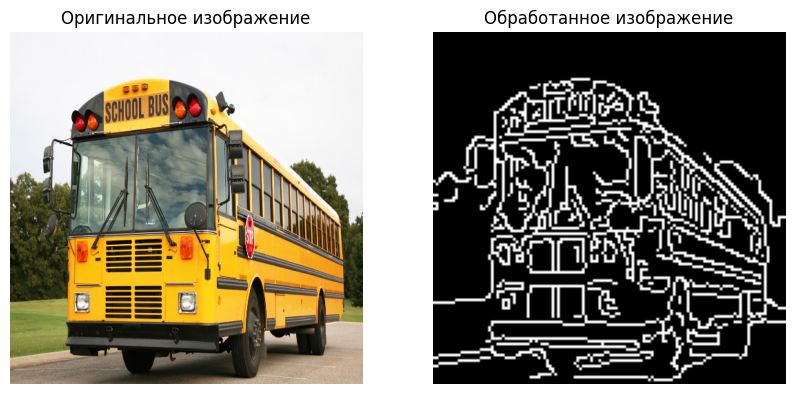

In [ ]:
def apply_filters(img):
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img_sharp = cv2.filter2D(img_blur, -1, kernel)
    img_edges = cv2.Canny(img_sharp, 100, 200)
    return img_edges

def preprocess_images(images):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, (128, 128))
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_eq = cv2.equalizeHist(img_gray)
        processed_images.append(img_eq)
    return np.array(processed_images)


processed_images = preprocess_images(images)

filtered_images = np.array([apply_filters(img) for img in processed_images])

def display_single_image(original, processed, index):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original[index], cv2.COLOR_BGR2RGB))
    plt.title('Оригинальное изображение')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed[index], cmap='gray')
    plt.title('Обработанное изображение')
    plt.axis('off')

    plt.show()

index = 0  
display_single_image(images, filtered_images, index)


Извлечение признаков

In [ ]:
import mahotas
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (512, 512))  
                    images.append(img)
                    labels.append(label)
    return images, labels

def extract_color_features(img):
    color_features = []
    for i in range(3):
        channel = img[:, :, i]
        mean = np.mean(channel)
        stddev = np.std(channel)
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256]).flatten()
        color_features.extend([mean, stddev])
        color_features.extend(hist)
    return np.array(color_features)

def extract_texture_features(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    haralick_features = mahotas.features.haralick(gray_img).mean(axis=0)
    return haralick_features

def extract_features(images):
    features = []
    for img in images:
        color_features = extract_color_features(img)
        texture_features = extract_texture_features(img)
        combined_features = np.hstack([color_features, texture_features])
        features.append(combined_features)
    return np.array(features)


images, labels = load_images_from_folder(folder_path)

features_array = extract_features(images)

labels_array = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42)

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10  2  4 10]
 [ 5 10  0  3]
 [ 7  5  1  5]
 [ 1  5  1 11]]
              precision    recall  f1-score   support

         Bus       0.43      0.38      0.41        26
         Car       0.45      0.56      0.50        18
       Truck       0.17      0.06      0.08        18
  motorcycle       0.38      0.61      0.47        18

    accuracy                           0.40        80
   macro avg       0.36      0.40      0.36        80
weighted avg       0.37      0.40      0.37        80



Обучение модели

In [ ]:
from sklearn.preprocessing import StandardScaler

images, labels = load_images_from_folder(folder_path)
features_array = extract_features(images)  

labels_array = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SVC(kernel='linear', C=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[12  2  4  8]
 [ 4 12  1  1]
 [ 7  6  2  3]
 [ 5  4  1  8]]
              precision    recall  f1-score   support

         Bus       0.43      0.46      0.44        26
         Car       0.50      0.67      0.57        18
       Truck       0.25      0.11      0.15        18
  motorcycle       0.40      0.44      0.42        18

    accuracy                           0.42        80
   macro avg       0.39      0.42      0.40        80
weighted avg       0.40      0.42      0.40        80



Задача аугментации для 10 случайных изображений

In [ ]:
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator

def augment_data(images, labels):
    datagen = ImageDataGenerator(rotation_range=10,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.1,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

    augmented_images = []
    augmented_labels = []

    for label in np.unique(labels):
        label_images = images[labels == label]

        for img in label_images:
            if len(img.shape) == 2:
                img = np.expand_dims(img, axis=-1)
            img = np.expand_dims(img, axis=0)

            for _ in range(10):
                aug_iter = datagen.flow(img)
                aug_img = next(aug_iter)[0].astype(np.uint8)
                augmented_images.append(aug_img.squeeze())
                augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

def extract_color_features(img):
    color_features = []
    if len(img.shape) == 2:
        mean = np.mean(img)
        stddev = np.std(img)
        hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
        color_features.extend([mean, stddev])
        color_features.extend(hist)
    else:
        for i in range(img.shape[2]):
            channel = img[:, :, i]
            mean = np.mean(channel)
            stddev = np.std(channel)
            hist = cv2.calcHist([channel], [0], None, [256], [0, 256]).flatten()
            color_features.extend([mean, stddev])
            color_features.extend(hist)
    return np.array(color_features)

def extract_texture_features(img):
    if len(img.shape) == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    haralick_features = mahotas.features.haralick(gray_img).mean(axis=0)
    return haralick_features

def extract_features(images):
    features = []
    for img in images:
        color_features = extract_color_features(img)
        texture_features = extract_texture_features(img)
        combined_features = np.hstack([color_features, texture_features])
        features.append(combined_features)
    return np.array(features)

labels = np.array(labels)
print("Processed images shape:", processed_images.shape)
print("Labels shape:", labels.shape)

if len(processed_images.shape) == 3:
    processed_images = np.expand_dims(processed_images, axis=-1)

augmented_images, augmented_labels = augment_data(processed_images, labels)
print("Augmented images shape:", augmented_images.shape)
print("Augmented labels shape:", augmented_labels.shape)

augmented_images_rgb = np.repeat(augmented_images, 3, axis=-1)
print("Augmented images shape after converting to RGB:", augmented_images_rgb.shape)

augmented_features = extract_features(augmented_images_rgb)
print("Augmented features shape:", augmented_features.shape)

X_aug_train, X_aug_test, y_aug_train, y_aug_test = train_test_split(augmented_features, augmented_labels, test_size=0.2, random_state=42)
print("Train features shape:", X_aug_train.shape)
print("Test features shape:", X_aug_test.shape)

scaler = StandardScaler()
X_aug_train = scaler.fit_transform(X_aug_train)
X_aug_test = scaler.transform(X_aug_test)

model.fit(X_aug_train, y_aug_train)

y_aug_pred = model.predict(X_aug_test)
print(classification_report(y_aug_test, y_aug_pred))
print(confusion_matrix(y_aug_test, y_aug_pred))


Processed images shape: (400, 128, 128)
Labels shape: (400,)
Augmented images shape: (4000, 128, 128)
Augmented labels shape: (4000,)
Augmented images shape after converting to RGB: (4000, 128, 384)
Augmented features shape: (4000, 271)
Train features shape: (3200, 271)
Test features shape: (800, 271)
              precision    recall  f1-score   support

         Bus       0.60      0.73      0.66       209
         Car       0.76      0.63      0.69       213
       Truck       0.66      0.62      0.64       194
  motorcycle       0.67      0.67      0.67       184

    accuracy                           0.67       800
   macro avg       0.67      0.66      0.67       800
weighted avg       0.67      0.67      0.67       800

[[152  15  20  22]
 [ 31 135  23  24]
 [ 42  16 121  15]
 [ 30  11  19 124]]


Модель в целом показывает сбалансированную точность и полноту на всех классах, а среднее значение accuracy составляет 67%.

Сводка по каждому классу:

Bus:
Правильно — 152
Ошибочно — 57

Car:
Правильно — 135
Ошибочно — 78

Truck:
Правильно — 121
Ошибочно — 73

Motorcycle:
Правильно — 124
Ошибочно — 60